![Logo](../../assets/logo.png)

Made by **Domonkos Nagy**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/3.%20Dynamic%20Programming/Jack's%20Car%20Rental/car_rental.ipynb)

# Jack’s Car Rental

Jack manages two locations for a nationwide car
rental company. Each day, some number of customers arrive at each location to rent cars.
If Jack has a car available, he rents it out and is credited \\$10 by the national company.
If he is out of cars at that location, then the business is lost. Cars become available for
renting the day after they are returned.

To help ensure that cars are available where
they are needed, Jack can move them between the two locations overnight, at a cost of
\\$2 per car moved. We assume that the number of cars requested and returned at each
location are Poisson random variables, meaning that the probability that the number is
n is $\frac{\lambda^n}{n!}e^{-\lambda}$, where $n$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at
the first and second locations and 3 and 2 for returns. 

One of Jack’s employees at the first location
rides a bus home each night and lives near the second location. She is happy to shuttle
one car to the second location for free. Each additional car still costs \\$2, as do all cars
moved in the other direction. In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of \\$4 must be incurred to use a second parking lot (independent of how
many cars are kept there).

To simplify the problem slightly,
we assume that there can be no more than 20 cars at each location (any additional cars
are returned to the nationwide company, and thus disappear from the problem) and a
maximum of five cars can be moved from one location to the other in one night. We take
the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where
the time steps are days, the state is the number of cars at each location at the end of
the day, and the actions are the net numbers of cars moved between the two locations
overnight.

This notebook uses *policy iteration* to find the optimal policy for this MDP.

In [1]:
import numpy as np
import math
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=0, suppress=True, linewidth=150)

In [2]:
# parameters
GAMMA = 0.9  # discount rate
LAMBDA_RENTALS_A = 3
LAMBDA_RENTALS_B = 4
LAMBDA_RETURNS_A = 3
LAMBDA_RETURNS_B = 2
POISSON_LIMIT = 11  # for any n over this, the probability is truncated to 0

In [3]:
# initalize value and policy tables
v_estimations = np.zeros((21, 21))
policy = np.zeros((21, 21), dtype=int)

In [4]:
poisson = {}

# calculating and storing poisson values for efficiency
for poisson_lambda in [LAMBDA_RENTALS_A, LAMBDA_RENTALS_B,LAMBDA_RETURNS_A, LAMBDA_RETURNS_B]:
    for n in range(POISSON_LIMIT):
        poisson[(poisson_lambda, n)] = (np.power(poisson_lambda, n) / math.factorial(n)) * np.exp(-poisson_lambda)

In [5]:
# calculate the expected value of an action in a given state
def action_value(state, action):
    N_CARS_A = state[0] - action
    N_CARS_B = state[1] + action

    # if the action is illegal in the state, we simply return -infinity
    if (N_CARS_A < 0 or N_CARS_B < 0 or N_CARS_A > 20 or N_CARS_B > 20):
        return -np.inf

    sum_reward = 0
    action_reward = abs(action) * -2

    # one car can be taken from a to b for free
    if action > 0:
        action_reward += 2

    # keeping more than 10 cars at a location has a cost of $4
    if N_CARS_A > 10:
        action_reward -= 4

    if N_CARS_B > 10:
        action_reward -= 4

    for n_rentals_a in range(POISSON_LIMIT):
        for n_rentals_b in range(POISSON_LIMIT):

            # number of rentals should not be higher than the number of available cars
            real_rentals_a = min(n_rentals_a, N_CARS_A)
            real_rentals_b = min(n_rentals_b, N_CARS_B)

            for n_returns_a in range(POISSON_LIMIT):
                for n_returns_b in range(POISSON_LIMIT):

                    # number of returns should not be higher than the max number of cars
                    n_cars_a = min(N_CARS_A - real_rentals_a + n_returns_a, 20)
                    n_cars_b = min(N_CARS_B - real_rentals_b + n_returns_b, 20)
                    new_state = (n_cars_a, n_cars_b)

                    # joint probability of the rentals and returns happening at both places
                    prob_rentals = poisson[(LAMBDA_RENTALS_A, n_rentals_a)] * poisson[(LAMBDA_RENTALS_B, n_rentals_b)]
                    prob_returns = poisson[(LAMBDA_RETURNS_A, n_returns_a)] * poisson[(LAMBDA_RETURNS_B, n_returns_b)]
                    prob = prob_returns * prob_rentals

                    # add the expected reward to the sum
                    rental_reward = 10 * (real_rentals_a + real_rentals_b)
                    reward = action_reward + rental_reward
                    sum_reward += prob * (reward + GAMMA * v_estimations[new_state])

    # this is the expected reward after taking the action and following the current policy after
    return sum_reward

## Policy iteration

As the name suggests, policy iteration is an iterative process for finding the optimal policy. It consists of two steps: *policy evaluation* and *policy improvement*. The policy evaluation step sets up the value function to accurately represent the value of each state, and then policy improvement updates the policy to be greedy with respect to the new value function. If the policy is unchanged from the last, the process is over, otherwise the policy evaluation step is called again.

In [6]:
# in-place policy evaluation
def policy_evaluation(theta=0.01):
    delta = theta

    while delta >= theta:
        delta = 0
        for n_cars_a in range(21):
            for n_cars_b in range(21):
                state = (n_cars_a, n_cars_b)

                old_value = v_estimations[state]
                action = policy[state]

                v_estimations[state] = action_value(state, action)
                delta = max(delta, abs(old_value - v_estimations[state]))

        print(f"delta={delta}")

In [7]:
def policy_improvement():
    print("Improving policy...")
    policy_stable = True

    for n_cars_a in range(21):
        for n_cars_b in range(21):
            state = (n_cars_a, n_cars_b)
            old_action = policy[state]

            action_values = {}

            # calculate the value of taking each action
            for action in range(-5, 6):
                action_values[action] = action_value(state, action)

            # keep a list of best actions, so if more equi-best actions are present,
            # and the new policy selects a different one than the old, policy_stable
            # is still True
            best_actions = []
            best_value = -np.inf

            for action, value in action_values.items():
                if value > best_value:
                    best_actions = [action]
                    best_value = value
                elif value == best_value:
                    best_actions.append(action)

            policy[state] = best_actions[0]
            policy_stable = policy_stable and old_action in best_actions

    return policy_stable

In [8]:
# iterate until optimal policy is found
policy_stable = False
i = 1

while not policy_stable:
    display.clear_output()
    print(f"*** Iteration #{i} ***")

    policy_evaluation()
    policy_stable = policy_improvement()
    i += 1

print("Found optimal policy")

*** Iteration #4 ***
delta=3.4589028557107895
delta=0.39644715354052096
delta=0.1730370987831975
delta=0.11064956389816416
delta=0.06986160027099686
delta=0.043340861834622046
delta=0.027081934944135355
delta=0.017270754799938004
delta=0.011404940987745249
delta=0.008245222934192498
Improving policy...
Found optimal policy


In [9]:
# print value table
print(v_estimations)

[[414. 423. 433. 443. 452. 460. 468. 476. 484. 491. 498. 505. 512. 518. 524. 528. 530. 534. 539. 542. 546.]
 [423. 433. 443. 453. 462. 470. 478. 486. 493. 500. 507. 514. 520. 526. 530. 534. 536. 541. 544. 548. 551.]
 [433. 443. 453. 462. 471. 480. 488. 495. 502. 509. 516. 522. 528. 532. 536. 540. 543. 546. 550. 553. 556.]
 [443. 453. 462. 471. 480. 489. 497. 504. 511. 518. 524. 530. 534. 538. 542. 545. 548. 552. 555. 558. 560.]
 [452. 462. 471. 480. 489. 497. 505. 512. 519. 526. 532. 536. 540. 544. 547. 550. 554. 557. 560. 562. 565.]
 [460. 470. 479. 488. 497. 505. 512. 519. 526. 533. 538. 542. 546. 549. 552. 556. 559. 562. 564. 567. 569.]
 [468. 478. 487. 496. 504. 512. 519. 526. 533. 539. 544. 548. 551. 554. 557. 561. 563. 566. 569. 571. 573.]
 [476. 485. 494. 503. 511. 519. 526. 533. 539. 545. 550. 553. 555. 558. 562. 565. 567. 570. 572. 575. 576.]
 [483. 492. 501. 510. 518. 525. 532. 539. 545. 550. 555. 557. 559. 562. 565. 568. 571. 573. 575. 577. 579.]
 [490. 499. 508. 516. 524. 5

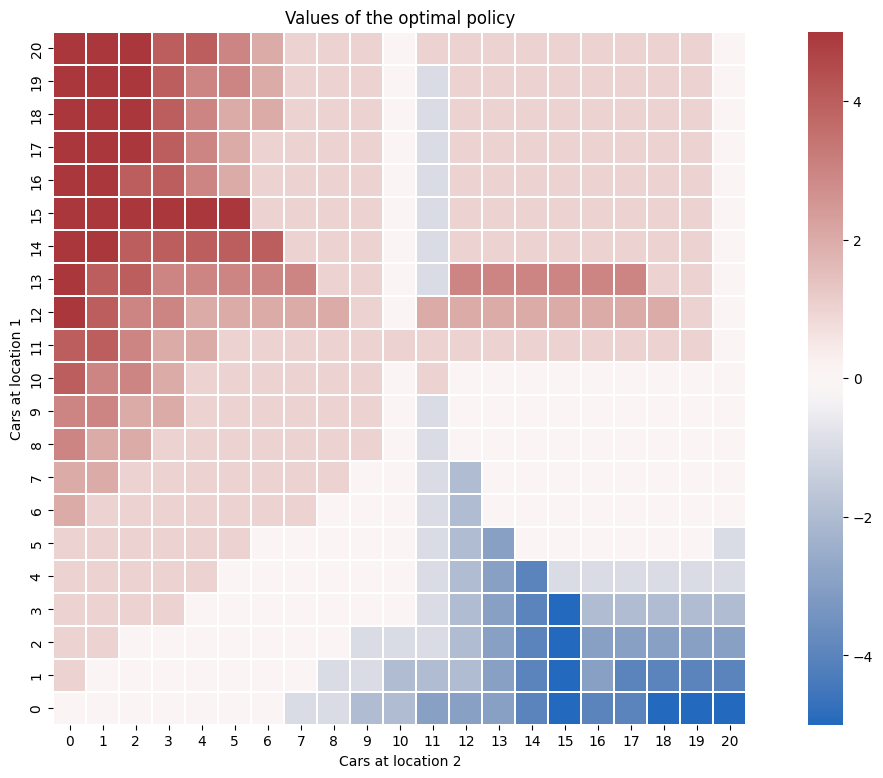

In [10]:
# print policy
plt.figure(figsize=(16, 9))

sns.heatmap(np.flip(policy, axis=0), cmap='vlag',
            linecolor='white', linewidths=0.05, square=True,
            yticklabels=np.arange(21 - 1, -1, -1))

plt.title('Values of the optimal policy')
plt.ylabel('Cars at location 1')
plt.xlabel('Cars at location 2')

plt.show()